# Lab12 - hyperparameter tuning

Name: Dylan Zucker 

Class: CSCI 349 - Intro to Data Mining

Semester: 2019SP

Instructor: Brian King

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from mlxtend.preprocessing import standardize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model
from keras import optimizers
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


### 1. Read in the wine data frame using the code given above. It also gives you the names of the variables, which should align according to the data information given on the UCI web page.

In [2]:
names = ["target","alcohol","malic_acid","ash","alcalinity","Mg","tot_phenols","flavanoids",
"non_flav_phenols","proanthocyanins","color_intensity",
"hue","OD","proline"]
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None,names=names)

### 2. Prepare your data. Minimally, you should be reporting:
    a) shape, info(), etc
    b) describe()
    c) Cast the type of the variables accordingly, particularly the target class
    d) Report on any missing data
    e) Show the head() of the data frame

In [3]:
df_wine.shape

(178, 14)

In [4]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
target              178 non-null int64
alcohol             178 non-null float64
malic_acid          178 non-null float64
ash                 178 non-null float64
alcalinity          178 non-null float64
Mg                  178 non-null int64
tot_phenols         178 non-null float64
flavanoids          178 non-null float64
non_flav_phenols    178 non-null float64
proanthocyanins     178 non-null float64
color_intensity     178 non-null float64
hue                 178 non-null float64
OD                  178 non-null float64
proline             178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


In [5]:
df_wine.describe()

,target,alcohol,malic_acid,ash,alcalinity,Mg,tot_phenols,flavanoids,non_flav_phenols,proanthocyanins,color_intensity,hue,OD,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [6]:
df_wine = df_wine.apply(pd.to_numeric)
target_type = pd.api.types.CategoricalDtype(categories = [1, 2, 3])
df_wine.target = df_wine.target.astype(target_type)
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
target              178 non-null category
alcohol             178 non-null float64
malic_acid          178 non-null float64
ash                 178 non-null float64
alcalinity          178 non-null float64
Mg                  178 non-null int64
tot_phenols         178 non-null float64
flavanoids          178 non-null float64
non_flav_phenols    178 non-null float64
proanthocyanins     178 non-null float64
color_intensity     178 non-null float64
hue                 178 non-null float64
OD                  178 non-null float64
proline             178 non-null int64
dtypes: category(1), float64(11), int64(2)
memory usage: 18.4 KB


In [7]:
df_wine.head()

,target,alcohol,malic_acid,ash,alcalinity,Mg,tot_phenols,flavanoids,non_flav_phenols,proanthocyanins,color_intensity,hue,OD,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### 3. Perform your EDA. Minimally, you should be reporting:
    a) Distributions of the target class
    b) Distributions of the variables
    c) Distributions of the variables, given each target class. Numeric and visual summaries are useful here.

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


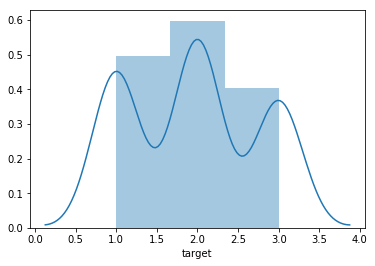

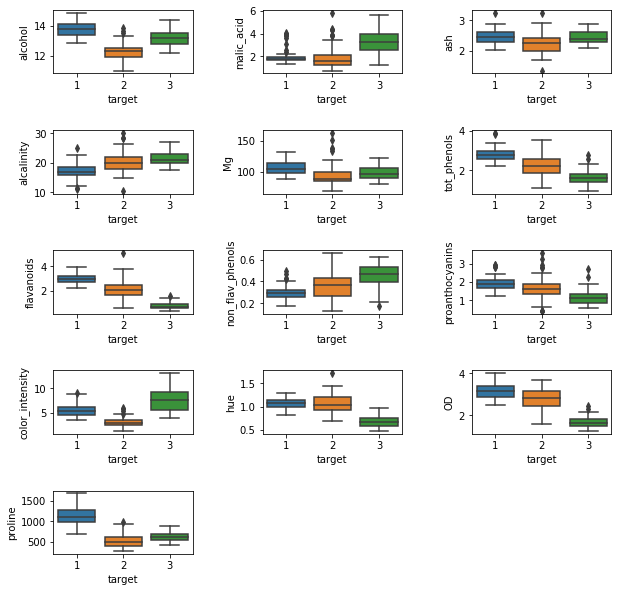

In [8]:
sns.distplot(df_wine["target"])
plt.title = "target"
plt.show()

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.9, wspace=0.5)
for i in range(1, len(df_wine.columns)):
    fig.add_subplot(5, 3, i)
    #sns.distplot(df_wine[df_wine.columns[i]]).set_title(df_wine.columns[i])
    sns.boxplot(x="target", y=df_wine.columns[i], data=df_wine)
plt.show()
    

### 4. Set up your X and y data frames to prepare for your modeling steps. Create X to be standardized across each variable. Create a binarized version of y as well, since you will be using Keras again, and the target variable is multi-class (i.e. more than two labels). And, again, it's very important that you shuffle your data.

In [9]:
X  = df_wine[["alcohol","malic_acid","ash","alcalinity","Mg","tot_phenols","flavanoids",
"non_flav_phenols","proanthocyanins","color_intensity",
"hue","OD","proline"]]
y = df_wine[["target"]]
X, y = shuffle(X, y, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

print(X_train.head())
print(y_train.head())
print(X_test.head())
print(y_test.head())

     alcohol  malic_acid   ash  alcalinity   Mg  tot_phenols  flavanoids  \
59     12.37        0.94  1.36        10.6   88         1.98        0.57   
16     14.30        1.92  2.72        20.0  120         2.80        3.14   
144    12.25        3.88  2.20        18.5  112         1.38        0.78   
89     12.08        1.33  2.30        23.6   70         2.20        1.59   
98     12.37        1.07  2.10        18.5   88         3.52        3.75   

     non_flav_phenols  proanthocyanins  color_intensity   hue    OD  proline  
59               0.28             0.42             1.95  1.05  1.82      520  
16               0.33             1.97             6.20  1.07  2.65     1280  
144              0.29             1.14             8.21  0.65  2.00      855  
89               0.42             1.38             1.74  1.07  3.21      625  
98               0.24             1.95             4.50  1.04  2.77      660  
     target_1  target_2  target_3
59          0         1         0
1

### 5. Let's induce a basic Decision Tree Classifier (i.e. DecisionTreeClassifier()). Don't set any initial parameters. Let the default tree induction parameters be used. Evaluate the tree using a 5-fold cross validation. Perform a standard report of your class-wide performance metrics (i.e. using classification report). You should have all of this code completed from a previous lab. 

### What is the overall accuracy? Which class performs the best? The worst?

In [10]:
y_dum = pd.get_dummies(y)
kfold = KFold(5, random_state = 100, shuffle = True)
df_results = pd.DataFrame([],columns=["true y", "prediction"])
for train_index, test_index in kfold.split(X):
    X_train_t, X_test_t = X.loc[train_index], X.loc[test_index]
    y_train_t, y_test_t = y_dum.loc[train_index], y_dum.loc[test_index]
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train_t, y_train_t)
    y_pred = clf.predict(X_test_t)
    y_test_unbin = y_test_t.apply(lambda x: 0 if x["target_1"] == 1 else 1 if x["target_2"] == 1 else 2, axis = 1)
    y_pred_unbin = []
    for x in y_pred:
        if x[0] == 1:
             y_pred_unbin.append(0)
        elif x[1] == 1:
             y_pred_unbin.append(1)
        else:
            y_pred_unbin.append(2)
    row = pd.DataFrame({"true y": y_test_unbin, "prediction": y_pred_unbin})
    df_results = df_results.append(row)

cm = confusion_matrix(np.array(df_results["true y"].values).astype("int"),np.array( df_results["prediction"].values).astype("int"))
print(cm)
df_results = df_results.apply(pd.to_numeric)
print(classification_report(df_results["true y"], df_results["prediction"])) 
# Target Class 1 performed the best. Target class 2 performed the worst


[[54  3  2]
 [ 4 60  7]
 [ 2  5 41]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        59
           1       0.88      0.85      0.86        71
           2       0.82      0.85      0.84        48

   micro avg       0.87      0.87      0.87       178
   macro avg       0.87      0.87      0.87       178
weighted avg       0.87      0.87      0.87       178



### 6. Perhaps we can do better. After all, if you look at the default parameter values for DecisionTreeClassifier, there are an enormous number of parameters to tree induction.

### Let's introduce you to GridSearchCV to evaluate many different decision tree parameters. There are TWO important parameters to GridSearchCV:
    a) estimator – this is the model that you will evaluate, that implements the scikit-learn estimator interface (which is pretty much every model implemented in scikit-learn!)
    b) param_grid – this is a dictionary with parameters of your model as keys, and a list of values to test as the value of each key. Look at the page for DecisionTreeClassifier. For example: suppose we wanted to compare both measures of purity: "gini" and "entropy". And, suppose we wanted to compare different max_depth values. We could set up a param_grid parameter:
    param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3,4,5,6,7]
    }
    This represents 10 different runs (2 criterion * 5 max_depth), times the size of your cross-validation.

### Add the above param_grid dictionary, then copy the following into your code, paying close attention to the parameters (i.e. just don't copy code without understanding it!):

grid = GridSearchCV(DecisionTreeClassifier(), param_grid,
    return_train_score=True, cv=5)

grid_result = grid.fit(X,y)

### (Of course, if you did not use X and y, then you need to specify the variables you used here.)

### Execute your code. It should go ahead and evaluate all combinations of parameters you set up in your param_grid! Decision trees are pretty quick to learn, especially on small data sets such as this.

In [11]:
param_grid = { 'criterion' : ['gini', 'entropy'], 'max_depth' : [3,4,5,6,7] }
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, return_train_score=True, cv=5) 
grid_result = grid.fit(X,y)
print(grid_result)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)


/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 7. Cool! Now, you need to get access to the internals of grid_result. It contains a LOT of information. Look closely at the description of the return value on the documentation page for GridSearchCV. Then, show the best score, along with the best parameters for that score. (HINT best_score_ and best_params_)

In [12]:
print(grid.best_score_)
print(grid.best_params_)

0.9325842696629213
{'criterion': 'entropy', 'max_depth': 3}


### 8. What does the best "score" represent? What performance metric? How do you override it, if, for example, you want to use f1_macro?

The best score is the highest mean, with the best parameter setting for the best model. You can change it in the scoring parater in GridSearchCV.


### 9. Perhaps you want to see the train and test performance score of every run. Write the code to report the training and testing score and standard deviation for every parameter combination. Output your data in order of highest test score to lowest. How did you do compared to the default decision tree without any parameters? (HINT: This is easily done by casting the cv_results_ parameter to a DataFrame, and then using standard pandas data selection and sorting methods.)

In [13]:
temp = pd.DataFrame(grid_result.cv_results_)
temp = temp.sort_values(["mean_test_score"], ascending = False)
temp = temp.reset_index()

for i in range(len(temp)):
    print(temp["params"][i])
    print("Mean: ", temp["mean_test_score"][i])
    print("stdv: ", temp["std_test_score"][i])

{'criterion': 'entropy', 'max_depth': 3}
Mean:  0.9325842696629213
stdv:  0.054457359568965705
{'criterion': 'entropy', 'max_depth': 7}
Mean:  0.9325842696629213
stdv:  0.028023091992959683
{'criterion': 'entropy', 'max_depth': 4}
Mean:  0.9269662921348315
stdv:  0.054376804616028125
{'criterion': 'entropy', 'max_depth': 6}
Mean:  0.9269662921348315
stdv:  0.054376804616028125
{'criterion': 'entropy', 'max_depth': 5}
Mean:  0.9213483146067416
stdv:  0.05927583693150802
{'criterion': 'gini', 'max_depth': 3}
Mean:  0.8932584269662921
stdv:  0.07249126389287561
{'criterion': 'gini', 'max_depth': 5}
Mean:  0.8932584269662921
stdv:  0.057042162817959374
{'criterion': 'gini', 'max_depth': 7}
Mean:  0.8932584269662921
stdv:  0.059715309608359635
{'criterion': 'gini', 'max_depth': 6}
Mean:  0.8820224719101124
stdv:  0.06515136548406773
{'criterion': 'gini', 'max_depth': 4}
Mean:  0.8764044943820225
stdv:  0.08297855048760062


### 10. The default scoring parameter is accuracy, and you've already learned about how accuracy is not necessarily the best metric on unbalanced data. This data is only slightly unbalanced, so it is not a bad metric. However, you should understand how to choose a better scoring metric to identify the best results for these data. 

### In general, a macro-averaged f1 metric is a pretty good assessment of classifier performance when you have unbalanced data, as it will give you an honest assessment of how you are doing on the smallest classes.

### Redo the above steps, but you must accomplish three things:
    
    a) Add min_samples_split and min_samples_leaf criteria to your grid search. Choose the parameter values that make sense to you.
    b) Specify the scoring parameter to use both accuracy AND f1_macro. You'll likely also need to specify the refit parameter.
    c) Change your result to a full 10-fold cross validation. This could take some time, but gives a better assessment of the power of your classifier. Perhaps using 5 fold just wasn't quite enough data for each member?
### Again, output your results, showing the top five configurations by accuracy, and also by f1_macro. Comment on your results.

In [14]:
param_grid = { 'criterion' : ['gini', 'entropy'], 'max_depth' : [3,4,5,6,7], "min_samples_split":[2,3,4], "min_samples_leaf": [1,2,3] }
grid = GridSearchCV(DecisionTreeClassifier(),  param_grid, scoring=["accuracy","f1_macro"], return_train_score=True, refit="accuracy", cv=10) 
grid_result = grid.fit(X_train,y_train)
print(grid_result)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 6, 7], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
       scoring=['accuracy', 'f1_macro'], verbose=0)


/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 11. Discuss your findings. Did 10-fold make a difference? Did the additional parameters make a difference? Output the top 5 parameter configurations, along with the training and testing, sorted by accuracy, then sorted by f1_macro. Summarize.

10-fold and the new parameters did make a difference we have a different param set for best params when sorted.

In [15]:
print(grid.best_score_)
print(grid.best_params_)

0.9662921348314607
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [18]:
temp = pd.DataFrame.from_dict(grid_result.cv_results_, orient="columns")
temp = temp.sort_values(["mean_test_f1_macro","mean_test_accuracy"], ascending = False)
temp = temp.reset_index()
for i in range(5):
    print(temp["params"][i])
    print("Mean acc: ", temp["mean_test_accuracy"][i])
    print("Mean f1_macro: ", temp["mean_test_f1_macro"][i])

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean acc:  0.9662921348314607
Mean f1_macro:  0.9668539325842697
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}
Mean acc:  0.9662921348314607
Mean f1_macro:  0.9668539325842697
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean acc:  0.9662921348314607
Mean f1_macro:  0.9668539325842697
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3}
Mean acc:  0.9662921348314607
Mean f1_macro:  0.9668539325842697
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 4}
Mean acc:  0.9662921348314607
Mean f1_macro:  0.9668539325842697


### 12. Most of you should have some sort of multicore processor, even on the simplest laptops. You can easily take advantage of this. The default configuration of GridSearchCV is to NOT use any parallel processing, thus evaluating one model at a time. However, you could perhaps do 2 at a time! Do you have a CPU with more than 1 core? (Yes, you most likely do!)

### Redo the above, but try out the parameter n_jobs=2 (I also sometimes set pre_dispatch to the same number as n_jobs, just to control too much memory usage. Not really important for decision trees, but could be important for larger models! If you have a really juicy machine, try an even higher value of n_jobs. (NOTE: Don't go higher than the number of cores in your machine! Experiment by starting with only 2, and incrementally increase.)

### Do some basic time comparisons with different values of n_jobs. If you set it too high, you will start to discover diminishing returns, and will harm your timing more then help, so back off the value. I typically do
something simple:
<code>
import time
start_ts = time.time()
grid_result = grid.fit(X,y)
end_ts = time.time()
print("Time in seconds", end-ts - start_ts)
</code>

In [19]:
import time
param_grid = { 'criterion' : ['gini', 'entropy'], 'max_depth' : [3,4,5,6,7], "min_samples_split":[2,3,4], "min_samples_leaf": [1,2,3] }
start_ts = time.time()
grid = GridSearchCV(DecisionTreeClassifier(),  param_grid, scoring=["accuracy","f1_macro"], return_train_score=True, refit="accuracy", cv=10) 
grid_result = grid.fit(X_train,y_train)
end_ts = time.time()
print("For 1 job, ", end_ts - start_ts)
param_grid = { 'criterion' : ['gini', 'entropy'], 'max_depth' : [3,4,5,6,7], "min_samples_split":[2,3,4], "min_samples_leaf": [1,2,3] }
start_ts = time.time()
grid = GridSearchCV(DecisionTreeClassifier(),  param_grid, scoring=["accuracy","f1_macro"], return_train_score=True, refit="accuracy", cv=10, n_jobs=2) 
grid_result = grid.fit(X_train,y_train)
end_ts = time.time()
print("For 2 jobs, ", end_ts - start_ts)

For 1 job,  6.7975013256073


/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


For 2 jobs,  5.373535871505737


/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 13. OK. Now on to hyperparameter tuning for Keras. From the previous lab, copy over your code for the function create_keras_model(). Now, modify your base neural net structure to match the inputs and outputs for the wine dataset you are working on for this lab.
### Modify the parameters of your function to allow you to pass model parameters. In particular, you are going to want to evaluate a different optimizer, activation for the hidden layer, and number of hidden units. Modify your function to take these three additional parameters. You may name the parameters whatever you want, though generally it's good to keep them the same as the actual parameters used as you build your model.
### Once you have your new function, create your Keras classifier with KerasClassifier(). When you call this function, this is where you pass parameters such as epochs and batch_size. You don't want to wait long, so just use epochs=5 and a batch_size=4. (I would advise starting with verbose=1, just to make sure your model is training properly, and you notice the accuracy increasing and loss decreasing, then set verbose=0 when doing a bigger grid search on the next step.)
### (NOTE: I use Atom + Hydrogen most of the time. And, the editor tends to freeze on occasion when I have verbose=1 with a lot of output! Be patient, or just set verbose=0 the next time, so it's not trying to trap your output.)

In [34]:
def create_keras_model(num_hidden = 1, hidden_size = 10, activation="relu", opt = "adam", num_inputs = 13, num_outputs = 3):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim = num_inputs,activation = "relu"))
    for i in range(num_hidden - 1):
        model.add(Dense(hidden_size, activation = activation))
    
    model.add(Dense(num_outputs, activation = "softmax"))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [28]:
clf = KerasClassifier(build_fn=create_keras_model, verbose=1, epochs=5, batch_size=4)
hist = clf.fit(X_train, y_train)

Epoch 1/5
89/89 [==============================] - 1s 6ms/step - loss: 5.4388 - acc: 0.5955
Epoch 2/5
89/89 [==============================] - 0s 391us/step - loss: 5.3877 - acc: 0.6067
Epoch 3/5
89/89 [==============================] - 0s 653us/step - loss: 5.3818 - acc: 0.6292
Epoch 4/5
89/89 [==============================] - 0s 548us/step - loss: 5.4125 - acc: 0.6180
Epoch 5/5
89/89 [==============================] - 0s 484us/step - loss: 5.3783 - acc: 0.6517


### 14. Before you start your grid search, test out your classifier with a straight forward 5-fold cross validation. (Don't ever start jumping into grid search without verifying you have a reasonable model to start with!) Use the same exact code that you used to perform your first cross validation with the decision tree in the beginning of this lab. The only difference should be the classification model (AND THE BINARIZED y!) Report your results. (If you did it right, then you'll likely notice that your initial attempt at even a basic neural net here, with only 5 epochs is pretty good.)

In [33]:

y_dum = pd.get_dummies(y)
kfold = KFold(5, random_state = 100, shuffle = True)
df_results = pd.DataFrame([],columns=["true y", "prediction"])
for train_index, test_index in kfold.split(X):
    X_train_t, X_test_t = X.loc[train_index], X.loc[test_index]
    y_train_t, y_test_t = y_dum.loc[train_index], y_dum.loc[test_index]
    
    clf = KerasClassifier(build_fn=create_keras_model, verbose=0, epochs=5, batch_size=4)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test_t)
    y_test_unbin = y_test_t.apply(lambda x: 0 if x["target_1"] == 1 else 1 if x["target_2"] == 1 else 2, axis = 1)
    row = pd.DataFrame({"true y": y_test_unbin, "prediction": y_pred})
    df_results = df_results.append(row)

cm = confusion_matrix(np.array(df_results["true y"].values).astype("int"),np.array( df_results["prediction"].values).astype("int"))
print(cm)
df_results = df_results.apply(pd.to_numeric)
print(classification_report(df_results["true y"], df_results["prediction"])) 


[[29  9 21]
 [34 16 21]
 [16 10 22]]
              precision    recall  f1-score   support

           0       0.37      0.49      0.42        59
           1       0.46      0.23      0.30        71
           2       0.34      0.46      0.39        48

   micro avg       0.38      0.38      0.38       178
   macro avg       0.39      0.39      0.37       178
weighted avg       0.40      0.38      0.37       178



### 15. Finally, use GridSearchCV on Keras (and prepare to waitseveral minutes!) First, create a param_grid dictionary. You must, minimally, specify the following keys:
    a) 'optimizer' : ['adam','sgd']
    b) number of hidden units : 2 different numbers, one of which
    c) 'activation' : ['relu']
    d) 'epochs' : [5, 10]
    e) 'batch_size' : [4, 8]

### Create a new classifier, but be sure verbose=0. Then, just like you did with the decision tree, wrap that classifier model in a GridSearchCV instance. Use a cross validation of 5. (You'll be waiting long enough!) And, report your best You should get some pretty good results!

In [ ]:
model=KerasClassifier(build_fn=create_keras_model, verbose=0)
param_grid = { 'opt' : ['adam', 'sgd'], 'num_hidden' : [1,2], "hidden_size":[10,12], "activation":["relu"], "epochs":[5,10], "batch_size":[4,8] }
grid = GridSearchCV(model,  param_grid, return_train_score=True, cv=5) 
grid_result = grid.fit(X_train,y_train)

In [45]:
print("Best Score: ", grid_result.best_score_)
print("Best params: ", grid_result.best_params_)

Best Score:  0.449438202247191
Best params:  {'activation': 'relu', 'batch_size': 8, 'epochs': 10, 'hidden_size': 12, 'num_hidden': 2, 'opt': 'adam'}


In [ ]:
temp = pd.DataFrame(grid_result.cv_results_)
temp = temp.sort_values(["mean_test_score"], ascending = False)
temp = temp.reset_index()
for i in range(len(temp)):
    print(temp["params"][i])
    print("Mean: ", temp["mean_test_score"][i])
    print("stdv: ", temp["std_test_score"][i])


### 16. Study your results. Can you do even better? How close can you get to 100% accuracy on a 5-fold cross validation with Keras? Try a different activation... say... 'tanh'. Perhaps a few more hidden units? A bit larger batch size, but more epochs? See what happens....

In [47]:
model2=KerasClassifier(build_fn=create_keras_model, verbose=0)
param_grid2 = { 'opt' : ['adam'], 'num_hidden' : [2,3], "hidden_size":[10,12], "activation":["relu", "tanh"], "epochs":[10], "batch_size":[8,16] }
grid2 = GridSearchCV(model2,  param_grid2, return_train_score=True, cv=5) 
grid_result2 = grid2.fit(X_train, y_train)


/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score:  0.550561797752809
Best params:  {'activation': 'tanh', 'batch_size': 8, 'epochs': 10, 'hidden_size': 12, 'num_hidden': 3, 'opt': 'adam'}


In [51]:
print("Best Score: ", grid_result2.best_score_)
print("Best params: ", grid_result2.best_params_)


Best Score:  0.550561797752809
Best params:  {'activation': 'tanh', 'batch_size': 8, 'epochs': 10, 'hidden_size': 12, 'num_hidden': 3, 'opt': 'adam'}


In [ ]:
temp = pd.DataFrame(grid_result2.cv_results_)
temp = temp.sort_values(["mean_test_score"], ascending = False)
temp = temp.reset_index()

for i in range(len(temp)):
    print(temp["params"][i])
    print("Mean: ", temp["mean_test_score"][i])
    print("stdv: ", temp["std_test_score"][i])